In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, fetch_20newsgroups 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")

torch.manual_seed(42)
np.random.seed(42) # If using numpy for initial data generation

PyTorch Version: 2.3.0+cu118


### Naive Bayes Classifiers

<p>Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' therem with strong (naive) independence assumptions between the features.</p>
<p>
Key Idea: </br></br>
P(Class | Features) = [P(Features | Class) * P(Class)] / P(Features)

- P(Class | Features): Posterior probability (what we want to find)
- P(Features | Class): Likelihood of features given a class
- P(Class): Prior probability of the class
- P(Features): Evidence (marginal probability of features - acts as a normalizer, often ignored for prediction as it's constant for all classes)
</p>

<p>"Naive" Assumption: Features are conditionally independent given the class.</p>

P(feature_1, feature_2, ..., feature_n | Class) = P(feature_1 | Class) * P(feature_2 | Class) * ... * P(feature_n | Class)
<p>This simplifies the computation of the likelihood term. Despite this strong assumption, Naive Bayes often performs surprisingly well.</p>

### Gaussian Naive Bayes (for continuous features)
Assumes that continuous features associated with each class are distributed according to a Gaussian (Normal) distribution.

In [2]:
# Generate synthetic continuous data
X_gnb_np, y_gnb_np = make_classification(
    n_samples=200, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, class_sep=1.0, random_state=42
)

In [5]:
scaler_gnb = StandardScaler()
X_gnb_scaled_np = scaler_gnb.fit_transform(X_gnb_np)

In [6]:
X_gnb = torch.from_numpy(X_gnb_scaled_np).float()
y_gnb = torch.from_numpy(y_gnb_np).long() # Class labels should be long for indexing

In [7]:
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(
    X_gnb, y_gnb, test_size=0.25, random_state=42
)

In [8]:
X_train_gnb.shape, y_train_gnb.shape

(torch.Size([150, 2]), torch.Size([150]))

In [9]:
n_samples_gnb, n_features_gnb = X_train_gnb.shape
classes_gnb = torch.unique(y_train_gnb)
n_classes_gnb = len(classes_gnb)
classes_gnb, n_classes_gnb

(tensor([0, 1]), 2)

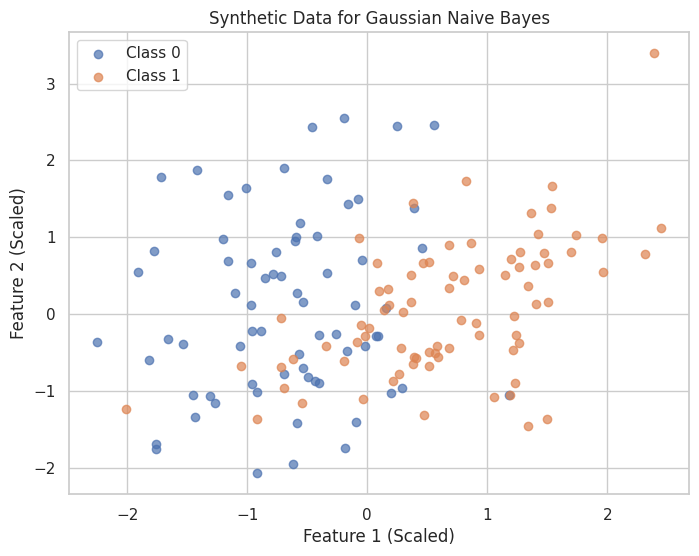

In [10]:
# Visualize
plt.figure(figsize=(8, 6))
for c_idx, c_val in enumerate(classes_gnb):
    class_mask = (y_train_gnb == c_val)
    plt.scatter(X_train_gnb[class_mask, 0].numpy(), X_train_gnb[class_mask, 1].numpy(),
                label=f'Class {c_val.item()}', alpha=0.7)
plt.xlabel("Feature 1 (Scaled)"); 
plt.ylabel("Feature 2 (Scaled)")
plt.title("Synthetic Data for Gaussian Naive Bayes"); 
plt.legend(); 
plt.show()

In [13]:
# Gaussian Naive Bayes 
class PyTorchGaussianNB:
    def __init__(self):
        self.class_priors_ = None   # P(Class)
        self.class_means_ = None    # Mean of features for each class
        self.class_vars_ = None     # Variance of features for each class
        self.classes_ = None        # Unique class labels found in training data
        self.epsilon_ = 1e-9        # To prevent division by zero in variance

    def fit(self, X_train_tensor, y_train_tensor):
        n_samples, n_features = X_train_tensor.shape
        self.classes_ = torch.unique(y_train_tensor)
        n_classes = len(self.classes_)

        # Initialize parameters
        self.class_priors_ = torch.zeros(n_classes, dtype=X_train_tensor.dtype, device=X_train_tensor.device)
        self.class_means_ = torch.zeros((n_classes, n_features), dtype=X_train_tensor.dtype, device=X_train_tensor.device)
        self.class_vars_ = torch.zeros((n_classes, n_features), dtype=X_train_tensor.dtype, device=X_train_tensor.device)

        for idx, c_val in enumerate(self.classes_):
            X_c = X_train_tensor[y_train_tensor == c_val]   
            # class prior P(Class = c_val)
            self.class_priors_[idx] = X_c.shape[0] / float(n_samples)
            # mean of features for class c_val
            self.class_means_[idx, :] = torch.mean(X_c, dim=0)
            # variance of features for class c_val
            self.class_vars_[idx, :] = torch.var(X_c, dim=0) + self.epsilon_

        print(f"Class Priors: {self.class_priors_}")

    def _gaussian_pdf(self, x_sample_feature, mean_feature, var_feature):
        """
        Computes PDF of Gaussian N(mean_feature, var_feature) for a single feature value x_sample_feature.
        """
        numerator = torch.exp(-((x_sample_feature - mean_feature)**2)/(2*var_feature))
        denominator = torch.sqrt(2 * torch.pi * var_feature)
        return numerator / denominator

    def _predict_log_probs(self, x_sample_tensor):
        """
        Predicts log probabilities for a single sample x_sample_tensor.
        x_sample_tensor shape: [n_features]
        """
        log_posteriors_sample = torch.zeros(len(self.classes_), dtype=x_sample_tensor.dtype, device=x_sample_tensor.device)

        for idx, c_val in enumerate(self.classes_):
            log_prior_c = torch.log(self.class_priors_[idx])

            # Calculate log likelihood P(Features | Class = c_val)
            # P(x_1, ..., x_n | C) = P(x_1|C) * ... * P(x_n|C)  (naive assumption)
            # log P(Features | C) = sum(log P(x_j | C))
            log_likelihood_c = 0.0
            for feature_j in range(x_sample_tensor.shape[0]):
                pdf_val = self._gaussian_pdf(
                    x_sample_tensor[feature_j],
                    self.class_means_[idx, feature_j],
                    self.class_vars_[idx, feature_j]
                )
                log_likelihood_c += torch.log(pdf_val + self.epsilon_)
            log_posteriors_sample[idx] = log_prior_c + log_likelihood_c
        return log_posteriors_sample

    def predict_probs(self, X_test_tensor):
        """ Predicts class probabilities for X_test_tensor """
        log_posteriors = torch.stack([self._predict_log_probs(x_sample) for x_sample in X_test_tensor])
        # Convert log posteriors to probabilities by exponentiating and normalizing
        # Subtract max for numerical stability before exp (log-sum-exp trick)
        max_log_post = torch.max(log_posteriors, dim=1, keepdim=True)[0]
        exp_log_post = torch.exp(log_posteriors - max_log_post)
        sum_exp_log_post = torch.sum(exp_log_post, dim=1, keepdim=True)
        probabilities = exp_log_post / sum_exp_log_post
        return probabilities


    def predict(self, X_test_tensor):
        """ Predicts class labels for X_test_tensor """
        log_posteriors = torch.stack([self._predict_log_probs(x_sample) for x_sample in X_test_tensor])
        # Class with highest log posterior is the prediction
        _, predicted_indices = torch.max(log_posteriors, dim=1)
        return self.classes_[predicted_indices]

In [14]:
# Train Gaussian Naive Bayes
gnb_model_torch = PyTorchGaussianNB()
gnb_model_torch.fit(X_train_gnb, y_train_gnb)

Class Priors: tensor([0.4667, 0.5333])


In [22]:
X_train_gnb.device

device(type='cpu')

In [19]:
# Predictions
y_pred_gnb_torch = gnb_model_torch.predict(X_test_gnb)
y_proba_gnb_torch = gnb_model_torch.predict_probs(X_test_gnb) 

In [20]:
y_proba_gnb_torch[:5]

tensor([[0.8678, 0.1322],
        [0.2741, 0.7259],
        [0.3738, 0.6262],
        [0.4124, 0.5876],
        [0.1096, 0.8904]])

In [23]:
accuracy_gnb_torch = accuracy_score(y_test_gnb.cpu(), y_pred_gnb_torch.cpu())
cm_gnb_torch = confusion_matrix(y_test_gnb.cpu(), y_pred_gnb_torch.cpu())
print(f"\nPyTorch GaussianNB Accuracy: {accuracy_gnb_torch:.4f}")
print(f"PyTorch GaussianNB Confusion Matrix:\n{cm_gnb_torch}")


PyTorch GaussianNB Accuracy: 0.9000
PyTorch GaussianNB Confusion Matrix:
[[26  4]
 [ 1 19]]


In [24]:
def plot_nb_decision_boundary(X_data_tensor, y_data_tensor, model, title="Naive Bayes Decision Boundary"):
    plt.figure(figsize=(8, 6))
    unique_classes = torch.unique(y_data_tensor)
    colors = ['skyblue', 'salmon', 'lightgreen', 'gold'] # Add more if more classes

    for i, c_val in enumerate(unique_classes):
        class_mask = (y_data_tensor == c_val)
        plt.scatter(X_data_tensor[class_mask, 0].cpu().numpy(), X_data_tensor[class_mask, 1].cpu().numpy(),
                    label=f'Class {c_val.item()}', color=colors[i % len(colors)], alpha=0.7, edgecolors='k')

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    xx_np = np.linspace(xlim[0], xlim[1], 100)
    yy_np = np.linspace(ylim[0], ylim[1], 100)
    YY_np, XX_np = np.meshgrid(yy_np, xx_np)
    
    xy_plot_np = np.vstack([XX_np.ravel(), YY_np.ravel()]).T
    xy_plot_tensor = torch.from_numpy(xy_plot_np).float().to(X_data_tensor.device)
    
    with torch.no_grad():
        Z_pred_tensor = model.predict(xy_plot_tensor)  
    Z_pred_np = Z_pred_tensor.cpu().numpy().reshape(XX_np.shape)

    plt.contourf(XX_np, YY_np, Z_pred_np, alpha=0.3, cmap=plt.cm.coolwarm) # Use coolwarm for binary
    
    plt.xlabel("Feature 1 (Scaled)"); 
    plt.ylabel("Feature 2 (Scaled)")
    plt.title(title); 
    plt.legend(); 
    plt.show()

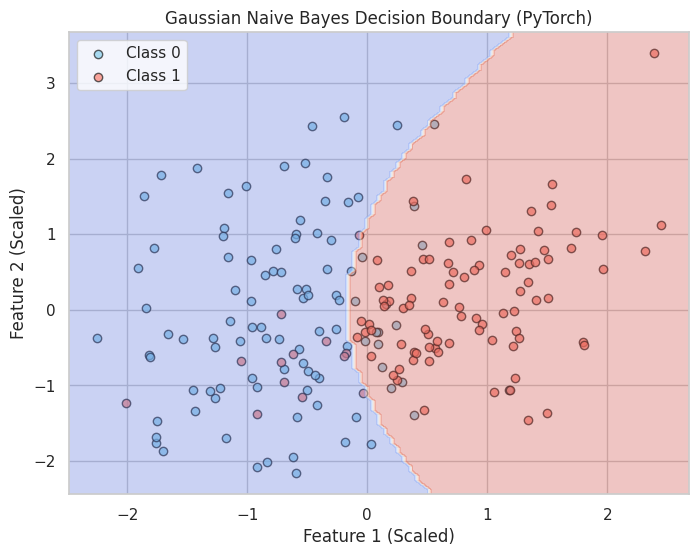

In [25]:
plot_nb_decision_boundary(X_gnb, y_gnb, gnb_model_torch, "Gaussian Naive Bayes Decision Boundary (PyTorch)")

### Multinomial Naive Bayes (for discrete features, e.g. word counts)
<p>Assumes features are generated from a multinomial distribution (counts of events). Common in text classification where features are word counts or TF-IDF values. Likelihood P(feature_j = k | Class) is estimated from frequency of feature value k in documents of that class. Often uses Laplace (additive) smoothing to handle unseen features in test data.</p>

In [43]:
# load text data 
# For simplicity, we'll use a small subset of categories
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
# newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
# newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

In [44]:
# simulating some text data for simplicity
sim_docs_train = [
    "god is love", "jesus saves sinners", "church prayer faith", # Class 0 (Religion)
    "faith in god", "christianity today",
    "computer graphics animation", "opengl directx rendering", # Class 1 (Graphics)
    "3d models shaders", "gpu performance",
    "medical science health", "disease treatment medicine", # Class 2 (Medicine)
    "doctor patient care", "clinical trials"
]
sim_labels_train_np = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])

In [45]:
sim_docs_test = [
    "prayer and faith", "love of god",
    "new graphics card", "computer animation software",
    "health benefits medicine", "cancer treatment research"
]
sim_labels_test_np = np.array([0, 0, 1, 1, 2, 2])

In [46]:
# Convert text to word counts (Bag-of-Words model)
vectorizer = CountVectorizer(stop_words='english', lowercase=True)
X_counts_train_np = vectorizer.fit_transform(sim_docs_train).toarray() # Convert sparse to dense for PyTorch
X_counts_test_np = vectorizer.transform(sim_docs_test).toarray()

In [47]:
# Convert to PyTorch Tensors
X_counts_train = torch.from_numpy(X_counts_train_np).float() # Features are counts
y_labels_train = torch.from_numpy(sim_labels_train_np).long()
X_counts_test = torch.from_numpy(X_counts_test_np).float()
y_labels_test = torch.from_numpy(sim_labels_test_np).long()

In [48]:
X_counts_train.shape, y_labels_train.shape

(torch.Size([13, 32]), torch.Size([13]))

In [49]:
n_samples_mnb, n_features_mnb = X_counts_train.shape
classes_mnb = torch.unique(y_labels_train)
n_classes_mnb = len(classes_mnb)
vocabulary_size = n_features_mnb
vocabulary_size, classes_mnb

(32, tensor([0, 1, 2]))

In [50]:
# Multinomial Naive Bayes
class PyTorchMultinomialNB:
    def __init__(self, alpha=1.0): # alpha for Laplace smoothing
        self.class_priors_ = None       # P(Class)
        self.feature_log_probs_ = None # Log P(Feature_j | Class) - log probabilities of features given class
        self.classes_ = None
        self.alpha_ = alpha             # Smoothing parameter

    def fit(self, X_train_counts_tensor, y_train_labels_tensor):
        n_samples, n_features = X_train_counts_tensor.shape
        self.classes_ = torch.unique(y_train_labels_tensor)
        n_classes = len(self.classes_)

        self.class_priors_ = torch.zeros(n_classes, dtype=X_train_counts_tensor.dtype, device=X_train_counts_tensor.device)
        # For P(feature_j | class_c): count(feature_j in class_c) / sum_all_feature_counts_in_class_c
        # Store log probabilities for numerical stability and to sum instead of multiply later.
        # Shape: [n_classes, n_features]
        self.feature_log_probs_ = torch.zeros((n_classes, n_features), dtype=X_train_counts_tensor.dtype, device=X_train_counts_tensor.device)

        for idx, c_val in enumerate(self.classes_):
            X_c = X_train_counts_tensor[y_train_labels_tensor == c_val] # Docs in current class c_val
            
            # Class prior P(Class = c_val)
            self.class_priors_[idx] = X_c.shape[0] / float(n_samples)
            
            # Calculate feature counts for class c_val
            # sum_feature_counts_in_class_c_j = sum of counts of feature j over all docs in class c
            feature_counts_in_class_c = torch.sum(X_c, dim=0) # Shape: [n_features]
            
            # Total count of all words in all documents of class c_val
            total_word_count_in_class_c = torch.sum(feature_counts_in_class_c)
            
            # Calculate log P(feature_j | class_c) with Laplace smoothing
            # P(w_j | C) = (count(w_j, C) + alpha) / (total_words_in_C + alpha * vocab_size)
            log_numerator = torch.log(feature_counts_in_class_c + self.alpha_)
            log_denominator = torch.log(total_word_count_in_class_c + self.alpha_ * n_features) # n_features is vocab_size
            
            self.feature_log_probs_[idx, :] = log_numerator - log_denominator
            
        print("MultinomialNB Fit Complete.")
        print(f"  Class Priors: {self.class_priors_}")

    def _predict_log_probs(self, x_sample_counts_tensor):
        """
        Predicts log probabilities for a single sample (document word counts).
        x_sample_counts_tensor shape: [n_features]
        """
        log_posteriors_sample = torch.zeros(len(self.classes_), dtype=x_sample_counts_tensor.dtype, device=x_sample_counts_tensor.device)
        
        for idx, c_val in enumerate(self.classes_):
            log_prior_c = torch.log(self.class_priors_[idx])
            
            # log P(Features | C) = sum_j (count(feature_j_in_sample) * log P(feature_j | C))
            # This is because features are word counts. If feature_j appears k times,
            # its contribution to log likelihood is k * log P(feature_j | C).
            # This uses the multinomial model property.
            # self.feature_log_probs_ already stores log P(feature_j | C)
            log_likelihood_c = torch.sum(x_sample_counts_tensor * self.feature_log_probs_[idx, :])
            
            log_posteriors_sample[idx] = log_prior_c + log_likelihood_c
            
        return log_posteriors_sample

    def predict_probs(self, X_test_counts_tensor):
        log_posteriors = torch.stack([self._predict_log_probs(x_sample) for x_sample in X_test_counts_tensor])
        max_log_post = torch.max(log_posteriors, dim=1, keepdim=True)[0]
        exp_log_post = torch.exp(log_posteriors - max_log_post)
        sum_exp_log_post = torch.sum(exp_log_post, dim=1, keepdim=True)
        probabilities = exp_log_post / sum_exp_log_post
        return probabilities

    def predict(self, X_test_counts_tensor):
        log_posteriors = torch.stack([self._predict_log_probs(x_sample) for x_sample in X_test_counts_tensor])
        _, predicted_indices = torch.max(log_posteriors, dim=1)
        return self.classes_[predicted_indices]

In [51]:
# Train Multinomial Naive Bayes
mnb_model_torch = PyTorchMultinomialNB(alpha=1.0) # alpha=1.0 is Laplace smoothing
mnb_model_torch.fit(X_counts_train, y_labels_train)

MultinomialNB Fit Complete.
  Class Priors: tensor([0.3846, 0.3077, 0.3077])


In [52]:
# Predictions
y_pred_mnb_torch = mnb_model_torch.predict(X_counts_test)

In [53]:
accuracy_mnb_torch = accuracy_score(y_labels_test.cpu().numpy(), y_pred_mnb_torch.cpu().numpy())
cm_mnb_torch = confusion_matrix(y_labels_test.cpu().numpy(), y_pred_mnb_torch.cpu().numpy())
report_mnb_torch = classification_report(y_labels_test.cpu().numpy(), y_pred_mnb_torch.cpu().numpy(), zero_division=0)

In [54]:
print(f"\nPyTorch MultinomialNB Accuracy: {accuracy_mnb_torch:.4f}")
print(f"PyTorch MultinomialNB Confusion Matrix:\n{cm_mnb_torch}")
print(f"PyTorch MultinomialNB Classification Report:\n{report_mnb_torch}")


PyTorch MultinomialNB Accuracy: 1.0000
PyTorch MultinomialNB Confusion Matrix:
[[2 0 0]
 [0 2 0]
 [0 0 2]]
PyTorch MultinomialNB Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



### Bernoulli Naive Bayes 
<p>Assumes features are binary (0 or 1, e.g. word presence/absence). Likelihood P(feature_j = 1 | Class) is estimated.</p>

In [56]:
# Implementation would be similar to Multinomial, but calculations for P(feature_j | Class)
# would be based on presence/absence rather than counts
# P(feature_j = f_val | C) = p_jc^f_val * (1-p_jc)^(1-f_val)
# where p_jc = P(feature_j = 1 | C)

In [57]:
if 'X_counts_train' in locals() and X_counts_train is not None: 
    print("Using binarized data from Multinomial NB example.")
    X_binary_train = (X_counts_train > 0).float() # Convert counts to binary (present/absent)
    y_binary_train = y_labels_train # Same labels
    X_binary_test = (X_counts_test > 0).float()
    y_binary_test = y_labels_test
else: # Generate new simple binary data if MNB data wasn't run
    print("Generating new synthetic binary data for Bernoulli NB.")
    X_bnb_np, y_bnb_np = make_classification(
        n_samples=150, n_features=5, n_informative=3, n_redundant=0, 
        n_clusters_per_class=1, random_state=43, flip_y=0.1
    )
    # Binarize the generated features (e.g., by thresholding at median or mean)
    # This is a bit artificial for make_classification but demonstrates the input type.
    X_bnb_binary_np = (X_bnb_np > np.median(X_bnb_np, axis=0)).astype(np.float32)

    X_binary_train_np, X_binary_test_np, y_binary_train_np, y_binary_test_np = train_test_split(
        X_bnb_binary_np, y_bnb_np, test_size=0.3, random_state=43
    )
    X_binary_train = torch.from_numpy(X_binary_train_np).float()
    y_binary_train = torch.from_numpy(y_binary_train_np).long()
    X_binary_test = torch.from_numpy(X_binary_test_np).float()
    y_binary_test = torch.from_numpy(y_binary_test_np).long()

Using binarized data from Multinomial NB example.


In [58]:
X_binary_train.shape,y_binary_train.shape

(torch.Size([13, 32]), torch.Size([13]))

In [60]:
n_samples_bnb, n_features_bnb = X_binary_train.shape
classes_bnb = torch.unique(y_binary_train)
n_classes_bnb = len(classes_bnb)
classes_bnb, n_features_bnb

(tensor([0, 1, 2]), 32)

In [63]:
# Bernoulli Naive Bayes 
class PyTorchBernoulliNB:
    def __init__(self, alpha=1.0): # alpha for Laplace smoothing
        self.class_priors_ = None          # P(Class)
        self.feature_log_probs_one_ = None # Log P(Feature_j = 1 | Class)
        self.classes_ = None
        self.alpha_ = alpha                # Smoothing parameter
        # Ensure alpha is a tensor for consistent operations if used with tensors
        self.alpha_tensor_ = None

    def fit(self, X_train_binary_tensor, y_train_labels_tensor):
        n_samples, n_features = X_train_binary_tensor.shape
        self.classes_ = torch.unique(y_train_labels_tensor)
        n_classes = len(self.classes_)

        # Convert alpha to a tensor on the same device and dtype as input for consistency
        self.alpha_tensor_ = torch.tensor(self.alpha_, dtype=X_train_binary_tensor.dtype, device=X_train_binary_tensor.device)

        self.class_priors_ = torch.zeros(n_classes, dtype=X_train_binary_tensor.dtype, device=X_train_binary_tensor.device)
        self.feature_log_probs_one_ = torch.zeros((n_classes, n_features), dtype=X_train_binary_tensor.dtype, device=X_train_binary_tensor.device)

        for idx, c_val in enumerate(self.classes_):
            X_c = X_train_binary_tensor[y_train_labels_tensor == c_val]
            # n_samples_c should be a tensor
            n_samples_c_tensor = torch.tensor(X_c.shape[0], dtype=X_train_binary_tensor.dtype, device=X_train_binary_tensor.device)
            
            # Class prior P(Class = c_val)
            self.class_priors_[idx] = n_samples_c_tensor / float(n_samples) # float(n_samples) is fine for divisor
            
            # Calculate P(feature_j = 1 | class_c) with Laplace smoothing
            # N_jc = count of samples in class C where feature j is 1
            # N_c = count of samples in class C
            # P(feature_j=1 | C) = (N_jc + alpha) / (N_c + K*alpha) where K=2 for binary
            
            count_feature_one_in_class_c = torch.sum(X_c, dim=0) # This is a tensor
            
            # Ensure all parts of numerator and denominator are tensors before log
            log_numerator = torch.log(count_feature_one_in_class_c + self.alpha_tensor_)
            
            # Denominator: n_samples_c_tensor + 2.0 * self.alpha_tensor_
            # Ensure 2.0 is also a tensor or correctly promotes
            denominator_val = n_samples_c_tensor + 2.0 * self.alpha_tensor_
            log_denominator = torch.log(denominator_val) # CORRECTED: denominator_val is now a tensor
            
            self.feature_log_probs_one_[idx, :] = log_numerator - log_denominator
            
        print("BernoulliNB Fit Complete.")
        print(f"  Class Priors: {self.class_priors_}")
        # print(f"  Feature Log Probs (P(Xj=1|C)) shape: {self.feature_log_probs_one_.shape}")


    def _predict_log_probs(self, x_sample_binary_tensor):
        log_posteriors_sample = torch.zeros(len(self.classes_), dtype=x_sample_binary_tensor.dtype, device=x_sample_binary_tensor.device)
        
        # Epsilon for numerical stability in log
        epsilon = torch.tensor(1e-9, dtype=x_sample_binary_tensor.dtype, device=x_sample_binary_tensor.device)

        for idx, c_val in enumerate(self.classes_):
            log_prior_c = torch.log(self.class_priors_[idx] + epsilon) # Add epsilon to prior too
            
            log_prob_feat_1_given_c = self.feature_log_probs_one_[idx, :] # log(P(Xj=1|C))
            
            # Calculate log(P(Xj=0|C)) carefully: log(1 - exp(log(P(Xj=1|C))))
            # p1 = P(Xj=1|C)
            prob_feat_1_given_c = torch.exp(log_prob_feat_1_given_c)
            # p0 = 1 - p1. Clamp p1 to avoid 1.0, which would make p0 = 0.
            prob_feat_0_given_c = 1.0 - torch.clamp(prob_feat_1_given_c, max=1.0 - epsilon.item())
            log_prob_feat_0_given_c = torch.log(prob_feat_0_given_c + epsilon)

            # log P(feature_j | C) for current sample's feature values (x_j)
            # log_likelihood_terms = x_j * log(P1) + (1-x_j) * log(P0)
            log_likelihood_terms = x_sample_binary_tensor * log_prob_feat_1_given_c + \
                                   (1.0 - x_sample_binary_tensor) * log_prob_feat_0_given_c
            
            log_likelihood_c = torch.sum(log_likelihood_terms)
            log_posteriors_sample[idx] = log_prior_c + log_likelihood_c
            
        return log_posteriors_sample

    # predict_probs and predict methods remain the same but will benefit from the epsilon in _predict_log_probs
    def predict_probs(self, X_test_binary_tensor):
        # Epsilon for numerical stability if a log_posterior is -inf before exp
        epsilon = torch.tensor(1e-30, dtype=X_test_binary_tensor.dtype, device=X_test_binary_tensor.device)

        log_posteriors_list = []
        for i in range(X_test_binary_tensor.shape[0]):
            x_sample = X_test_binary_tensor[i]
            log_posteriors_list.append(self._predict_log_probs(x_sample))
        
        log_posteriors = torch.stack(log_posteriors_list)
        
        # Subtract max for numerical stability before exp (log-sum-exp trick)
        max_log_post = torch.max(log_posteriors, dim=1, keepdim=True)[0]
        # If max_log_post is -inf (all log_posteriors were -inf), adding epsilon to avoid exp(-inf - (-inf)) = exp(nan)
        stable_log_posteriors = log_posteriors - max_log_post
        
        exp_log_post = torch.exp(stable_log_posteriors)
        sum_exp_log_post = torch.sum(exp_log_post, dim=1, keepdim=True)
        
        # Avoid division by zero if sum_exp_log_post is 0 (can happen if all log_posteriors were -inf)
        probabilities = exp_log_post / (sum_exp_log_post + epsilon)
        return probabilities

    def predict(self, X_test_binary_tensor):
        log_posteriors_list = []
        for i in range(X_test_binary_tensor.shape[0]):
            x_sample = X_test_binary_tensor[i]
            log_posteriors_list.append(self._predict_log_probs(x_sample))
        
        log_posteriors = torch.stack(log_posteriors_list)
        
        _, predicted_indices = torch.max(log_posteriors, dim=1)
        return self.classes_[predicted_indices]

In [64]:
# Train Bernoulli Naive Bayes
bnb_model_torch = PyTorchBernoulliNB(alpha=1.0)
bnb_model_torch.fit(X_binary_train, y_binary_train)

BernoulliNB Fit Complete.
  Class Priors: tensor([0.3846, 0.3077, 0.3077])


In [66]:
y_pred_bnb_torch = bnb_model_torch.predict(X_binary_test)
y_pred_bnb_torch

tensor([0, 0, 0, 1, 2, 0])

In [68]:
accuracy_bnb_torch = accuracy_score(y_binary_test.cpu().numpy(), y_pred_bnb_torch.cpu().numpy())
cm_bnb_torch = confusion_matrix(y_binary_test.cpu().numpy(), y_pred_bnb_torch.cpu().numpy())
report_bnb_torch = classification_report(y_binary_test.cpu().numpy(), y_pred_bnb_torch.cpu().numpy(), zero_division=0)

In [69]:
print(f"\nPyTorch BernoulliNB Accuracy: {accuracy_bnb_torch:.4f}")
print(f"PyTorch BernoulliNB Confusion Matrix:\n{cm_bnb_torch}")
print(f"PyTorch BernoulliNB Classification Report:\n{report_bnb_torch}")


PyTorch BernoulliNB Accuracy: 0.6667
PyTorch BernoulliNB Confusion Matrix:
[[2 0 0]
 [1 1 0]
 [1 0 1]]
PyTorch BernoulliNB Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       1.00      0.50      0.67         2
           2       1.00      0.50      0.67         2

    accuracy                           0.67         6
   macro avg       0.83      0.67      0.67         6
weighted avg       0.83      0.67      0.67         6



<p>Naive Bayes classifiers are simple yet often effective probabilistic models. Different variants (Gaussian, Multinomial, Bernoulli) cater to different types of feature data. Key steps involve calculating class priors and feature likelihoods, then applying Bayes' therem. Laplace/additive smoothing is important for handling unseen features in discrete models.</p>